In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, we define the data we want to load. You will need to have the data locally!

In [600]:
data_base = "data_gdp/"  # Path to data folder

data_names = ["aid_received", "gdp_per_capita", "investment", "exports",  "health_spending"]  # File names
#normalise_column = [False, False, False, False, False]
data_paths = [data_base + x + ".csv" for x in data_names]  # Lazy  
countries = ["Chile", "Peru", "Colombia", "Ecuador"]  # Countries we want to study
years = (2000, 2015)
#normalise_us = [data_names[i] for i in range(len(data_names)) if normalise_column[i]]

This function loads the data in a messy way.

In [601]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return float(x)

def k_to_1000(x):
    print(x)
    if "k" in x:
        print(x)
    return x.replace("k", "*e3")

def load_data(paths: list[str]) -> pd.DataFrame:
    df = None
    for path in paths:
        new_df = pd.read_csv(path).melt(id_vars=["country"], var_name="year",
                                        value_name=path.replace(data_base, "").replace(".csv", ""))
        if df is None:
            df = new_df
        else:
            df = pd.merge(df, new_df, on=["country", "year"])
    df["year"] = df["year"].apply(int)

    return df



Load data frame into memory:

In [602]:
df = load_data(data_paths)
df = df.loc[
    (df["country"].isin(countries)) & (df["year"] > years[0]) & (df["year"] < years[1])]  # Pick out the stuff we want.

df = df.rename(columns={"gdp_per_capita": "gdp_prior"})  # Makes things easier to write
df["gdp_posterior"] = None  # Init new column
for country in countries:  # Bad code! 
    # Creates a x_t+1 column
    df.loc[df["country"] == country, "gdp_posterior"] = df.loc[df["country"] == country, "gdp_prior"].shift(-1)
df = df.dropna()

numeric_columns = [x for x in df.columns if not (x == "country" or x == "year")]
print(numeric_columns)
for meme in numeric_columns:
    print(meme)
    if df[meme].dtype != object:
        continue
    try:
        replaced_col = df[meme].str.replace("k", "e3")
        if not replaced_col.isnull().values.any():
            df[meme] = replaced_col
    except:
        pass
print(df[numeric_columns])
df[numeric_columns] = df[numeric_columns].astype(float)
print(df)


['aid_received', 'gdp_prior', 'investment', 'exports', 'health_spending', 'gdp_posterior']
aid_received
gdp_prior
investment
exports
health_spending
gdp_posterior
     aid_received gdp_prior investment  exports  health_spending gdp_posterior
870           3.6      8720       5.87     31.8            159.0          8900
876          10.0      4010       2.59     15.4            125.0          4050
885          13.3      4320        2.2     23.2             27.0          4420
946          17.1      3260        2.2     16.6             55.8          3390
1011       -0.451      8900       3.63     32.3            157.0          9230
1017         11.3      4050       2.18     14.8            123.0          4140
1026         17.9      4420       2.74     21.5             36.3          4460
1087         18.2      3390       3.94     17.3             59.2          3500
1152         5.07      9230       5.26     35.1            134.0          9750
1158         19.9      4140       1.82     16.6

We say that $x_t = $gdp, and that 
$$
\dot x_t = \alpha x_t + \beta^Tu_t + u_t^T \gamma u_t.
$$
Thus, we have the finite time approximation 
$$
x_{t+1} = x_t + \delta t \dot x_t = x_t + \delta t\big( \alpha x_t + \beta^Tu_t + u_t^T \gamma u_t \big).
$$
This equation can be rewritten as 
$$
 x_{t+1} - \Big( x_t + \delta t\big( \alpha x_t + \beta^Tu_t + u_t^T \gamma u_t \big) \Big) = 0,
$$
and we can describe the model calibration as a MSE loss optimisation 
$$
\min_{\alpha, \beta} \frac{1}{\vert I \vert } \sum_{i \in I} \vert \vert x_{t+1} - \big( x_t + \delta t \dot x_t \big) \vert \vert,
$$
where $I$ is some indexing set for all of our samples. The only contraint we have is $\alpha \in R$, $\beta\in R^n$ and $\gamma \in R^{n \times n}$, where $n$ is the number of signals we have. 

We do the optimisation via scipy, because I know how to work it. 

In [603]:
import scipy.optimize as opt

In [604]:
def create_gamma(x, n_feat):
    ret = np.zeros((n_feat, n_feat))
    indices = np.triu_indices(n_feat)
    ret[indices] = x
    return ret


def function_to_optimise(x: np.ndarray, X: np.ndarray, delta_t: float) -> float:
    """
    The variable names here are confusing if compared to the previous notation. 
    
    x = [alpha, beta^T, flattened(gamma)]^T, 
    
    X is a (2+n)xm matrix of [x_t, u^T, x_{t+1}], 
    
    delta_t is the time step.
    """

    n_features = X.shape[1] - 2

    alpha = x[0]
    beta = x[1:1 + n_features]
    gamma = create_gamma(x[1 + n_features:], n_features)

    basic_error = X[:, -1] - ((1 + delta_t * alpha) * X[:, 0])
    linear_contribution = delta_t * X[:, 1:-1].dot(beta)
    quadratic_contribution = delta_t * (
            X[:, 1:-1].transpose() * (
        gamma.dot(X[:, 1:-1].transpose()
                  )
    )
    ).sum(axis=0)
    error_vector = basic_error - linear_contribution - quadratic_contribution
    return error_vector.dot(error_vector)

Now we construct our data matrix, and define our timestep $\delta t = 1 $:

In [605]:
delta_t = 1  # years

# Some book keeping
not_features = ["gdp_prior", "gdp_posterior", "year", "country"]
features = [x for x in df.columns if x not in not_features]


def create_X(df):
    df_size, df_n_features = df.shape[0], df.shape[1] - len(not_features)

    # Init X 
    X = np.zeros((df_size, df_n_features + 2))

    # Assign columns
    X[:, 0] = df["gdp_prior"]
    X[:, 1:-1] = df[features]
    X[:, -1] = df["gdp_posterior"]
    return X, df["year"].to_numpy()


X, _ = create_X(df)

Now we are ready to optimise!

In [606]:

func_lambda = lambda x: function_to_optimise(x, X,
                                             delta_t)  # Create a lambda which passes X and delta_t, since these are constants
initial_guess = np.ones(len(features) + 1 + np.triu_indices(len(features))[0].shape[0])
result = opt.minimize(func_lambda, x0=initial_guess, method='Nelder-Mead',
                      options={"maxiter": len(initial_guess) * 1000})

Now we can look at the result:

In [607]:
print(result)
n_feats = len(features)
print(result.x[:n_feats+1])
print(create_gamma(result.x[n_feats+1:], n_feats))
print(result.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 795335.9656977052
             x: [-5.037e-02  3.799e+00 ... -4.388e-02  1.437e-04]
           nit: 4427
          nfev: 5913
 final_simplex: (array([[-5.037e-02,  3.799e+00, ..., -4.388e-02,
                         1.437e-04],
                       [-5.037e-02,  3.799e+00, ..., -4.388e-02,
                         1.436e-04],
                       ...,
                       [-5.037e-02,  3.799e+00, ..., -4.388e-02,
                         1.437e-04],
                       [-5.037e-02,  3.799e+00, ..., -4.388e-02,
                         1.438e-04]]), array([ 7.953e+05,  7.953e+05, ...,  7.953e+05,  7.953e+05]))
[-0.05036697  3.79930438  6.49231533  2.69871428  4.84640698]
[[ 4.53979091e-01  2.68474438e+00 -7.54691449e-01 -1.60426476e-01]
 [ 0.00000000e+00  1.26064938e-01 -1.68406331e+00 -1.62827235e-01]
 [ 0.00000000e+00  0.00000000e+00  5.72213086e-01 -4.38777757e-02]
 

Or, we can compare our model estimate vs actual for some country of interest


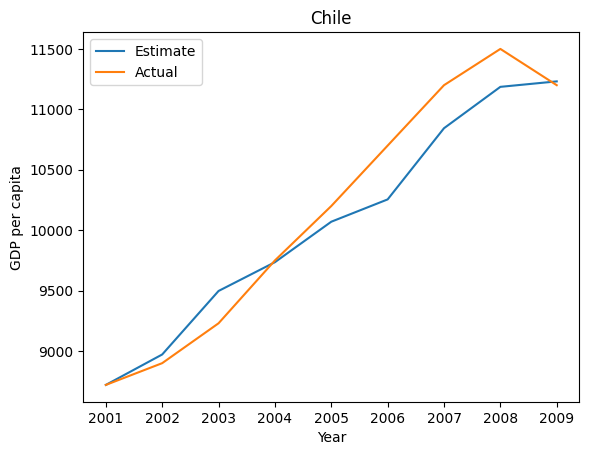

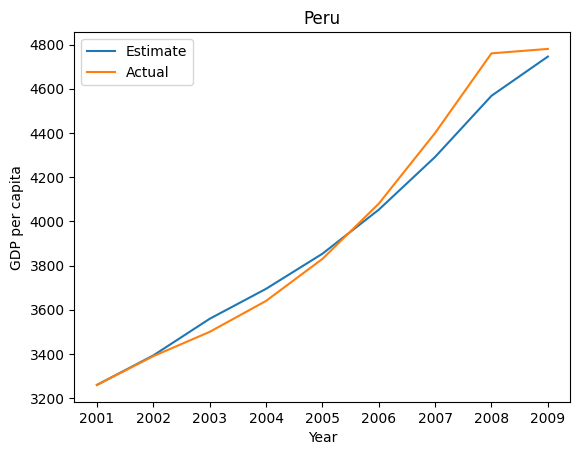

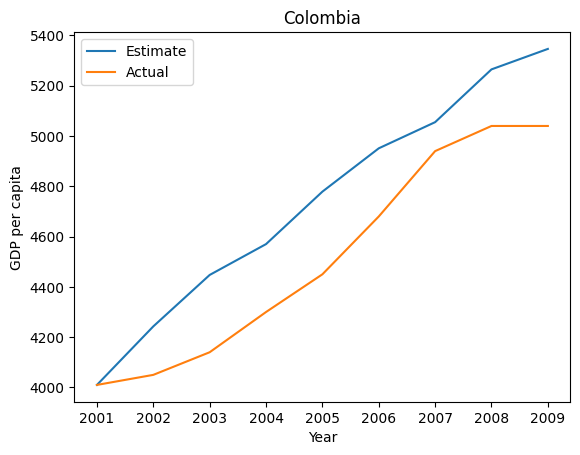

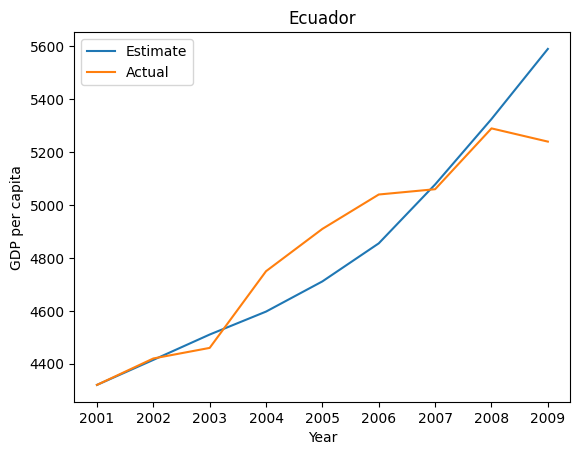

<Figure size 640x480 with 0 Axes>

In [608]:
def quick_sim(result, signals, initial_state, n_features=3):
    ret = [initial_state]
    c_state = initial_state
    alpha = result.x[0]
    beta = result.x[1:1 + n_features]
    gamma = create_gamma(result.x[1 + n_features:], n_features)
    for k in range(signals.shape[0]-1):
        c_state = c_state + delta_t * (
                alpha * c_state + signals[k, :].dot(beta) + signals[k, :].dot(gamma.dot(signals[k, :].transpose())))
        ret.append(c_state)
    return np.array(ret)

def plot_sim(df, country_of_interest):
    sub_df = df.loc[df["country"] == country_of_interest]
    sub_X, y = create_X(sub_df)
    
    estimate = quick_sim(result, sub_X[:, 1:-1], initial_state=sub_X[0, 0], n_features=len(features))
    actual = sub_X[:, 0]
    
    plt.plot(y, estimate, label="Estimate")
    plt.plot(y, actual, label="Actual")
    plt.xlabel("Year")
    plt.ylabel("GDP per capita")
    plt.title(country_of_interest)
    plt.legend()

for country_of_interest in countries:
    plot_sim(df, country_of_interest)
    plt.figure()





 The model works fairly well, but we should remember that we are looking at it in-sample. Now we can move on to figuring out a problem to optimise. The basic idea is to maximise GDP per capita, and our signals are contained in the 'features' list:

In [609]:
print(features)

['aid_received', 'investment', 'exports', 'health_spending']


All of these should be normalised for population size. 